<H1 style="text-align: center">ECMM422 - Machine Learning</H1>
<H2 style="text-align: center">Assignment 4: Reinforcement Learning</H2>

| Date set     | Hand-in date |
|:------------------|:-----------------------------------|
| 6th March 2020  | **  Wednesday 18th March ** |


This workshop is worth 25% of the total module mark.



Candidate number:  <font color="red">*660028124*</font>

Marking is anonymous, so please don't write your name or reveal your identity!



Your report should consist of your IPython notebook showing what you did, what was the
result, and what you can conclude from the exercise. Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

### Submitting the notebooks

Note that an electronic submission is required.  You should also submit the notebook electronically at [electronic hand-in system]( http://empslocal.ex.ac.uk/submit/).  You just need to submit the single .ipynb file that is the notebook, so you should be able to upload it directly from the directory where you have saved it on a University machine or your laptop.  If you're not sure where in your homespace it is, type <code>pwd</code> (print working directory) in a cell to find out where the notebooks are.

<b>Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission.</b>


<div class="alert alert-info">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 
</div>


In [1]:
# including libraries as usual
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
sns.set_style("darkgrid")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Gridworld example

The following code will provide you with a working gridworld problem. You are asked to study the code and use it to provide a solution in the following questions. 


In [2]:
class GridWorld: 
    '''
    Class implementing a typical GridWorld problem. 
    
    '''
    
    
    def __init__(self, width, height, gamma=1, penalty=-1, start=[0,0], goal=[0,0], cliff=[], cliff_penalty=-10):
        '''
        Generates a new Gridworld problem, with a grid of size (width,height). 
        gamma: reward discount parameter (default:1)
        penalty: penalty for each move (default:-1)
        start: start location (default: [0,0])
        goal: goal location (default: [0,0])
        cliff: list of locations defined as cliff (the agent incurs a large penalty for walking into cliffs and is transported back to the start). 
        cliff_penalty: penalty incurred for walking into a cliff (default: -100). 
        '''
        # define the four possible actions
        self.gamma = gamma
        self.actions = range(4)
        self.delta = np.array([[0,-1],[+1,0],[0,+1],[-1,0]])
        self.actions_labels = ['up','right','down','left']
#         self.action_dict = {"up": 0, "right": 1, "down": 2, "left": 3}
        self.states = range(width*height)
        self.width = width
        self.height = height
        
        # set the start state
        self.start = self.encode_state(start)     

        self.cliff = [self.encode_state(s) for s in cliff]
        self.goal = self.encode_state(goal)
        self.penalty = penalty
        self.cliff_penalty = cliff_penalty
        self.grid = np.zeros((height,width))
        for c in range(width): 
            for r in range(height): 
                if [c,r] == goal: 
                    self.grid[r,c] = 1
                elif [c,r] in cliff: 
                    self.grid[r,c] = 2
                elif [c,r] == start: 
                    self.grid[r,c] = 3
        
    def line_string(self):
        s = '+'
        for j in range(self.width):
            s += '-+'
        s += '\n'
        return s
        
    def tostring(self): 
        '''
            Converts the grid world to a formatted string. 
        '''
        s = 'Grid world:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                elif self.grid[r,c] == 3:
                    s += 'S'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s    
    
    def print_solution(self,S): 
        '''
        Graphical display of a solution S, given as a list of states that brings from the initial state to the goal. 
        '''
        s = 'Solution:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                p = self.encode_state((c,r))                
                
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 3:
                    s += 'S'
                elif p in S:
                    if p == S[-1]:
                        s += '@'
                    else:
                        s += '*'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s 
    
    def show_states(self):
        '''
        Displays state IDs on a grid. 
        '''
        print( np.array(self.states).reshape((self.width,self.height)).T )
    
    def encode_state(self,coord):
        '''
        Converts a tuple (c,r) containing grid coordinates to the corresponding (scalar) state ID. 
        '''
        (c,r) = coord
        if r<self.height and c<self.width and r>=0 and c>=0: 
            return int(c*self.height+r)
        else: 
            return -1
    
    def decode_state(self,s): 
        '''
        Converts a state ID into grid coordinates. 
        '''
        return (s//self.height,s%self.height)
        
    def state_action_state(self,s,a): 
        '''
        Generates the next state and associated reward for a state/action pair. 
        '''
        
        ns = self.encode_state(self.decode_state(s) + self.delta[a,:])
        
        if ns in self.cliff: 
            return [(self.start, self.cliff_penalty)]
        
        # if an invalid state is generated, stay where we are
        elif ns < 0: 
            return [(s,self.penalty)]
        
        # if the goal is reached, no penalty incurred. 
        elif ns == self.goal: 
            return [(ns,0)]
        
        else: 
            return [(ns,self.penalty)]
        
    def state_transition(self,s): 
        '''
        Generates lists of all possible action/next state/reward triplets for the current state. 
        Returns a triplet of lists (sv,pv,rv), with one element per action, where: 
        sv[a] is the next state following the action a.
        pv[a] is the likelihood to select action a (policy). 
        rv[a] is the immediate reward of selecting action a. 
        '''
        
        sv = np.zeros(len(self.actions),dtype='uint')
        #pv = np.zeros(len(self.actions))
        rv = np.zeros(len(self.actions))
        
        for a in self.actions: 
            (s2,r2) = self.state_action_state(s,a)[0]
            sv[a] = s2
            #pv[a] = 1.0/len(self.actions)
            rv[a] = r2
            
        return (sv,rv)

    
# print(show_states)
    
world = GridWorld(6,4, gamma=0.9, goal=[5,3], start=[0,3], cliff=[[1,3],[2,3],[3,3],[4,3]])



print( world.tostring() )

print('GridWorld state indexing:')
print(world.grid)
print()
print(world.states)
states = world.show_states() # A grid with their states. Grid of States
x_y = (1,1)
state = world.encode_state(x_y) # Find a specific state in the grid. 0~X

coord = world.decode_state(state) # Find the coordinated of a specific state in the grid.(x, y)
a = 0 # From 0 to 3
close = world.state_action_state(state,a) # Next state and associated reward [(4, -1)]
finalPosition, reward = close[0][0],close[0][1]

sv,rv = world.state_transition(state) #sv[a] = next state following the action a,rv[a] = immediate reward of selecting action a. [4 9 6 1], [-1. -1. -1. -1.]


Grid world:
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+

GridWorld state indexing:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [3. 2. 2. 2. 2. 1.]]

range(0, 24)
[[ 0  4  8 12 16 20]
 [ 1  5  9 13 17 21]
 [ 2  6 10 14 18 22]
 [ 3  7 11 15 19 23]]


## 1. Policy evaluation

One simple way to solve a reinforcement learning problem is to estimate the value function for the whole problem and then apply a greedy strategy to find the goal. In the first part you are asked to evaluate the value function V(s) for all states (ie, grid cells), using <b>policy iteration</b>, as discussed in class. 
Iterative policy evaluation proposes an update of the value function based on the recursive formulation of the <i>Bellman equation</i>: 

$$
V^{(t+1)}(S_t) \leftarrow \sum_{S_{t+1},R_{t+1}} p\left[S_{t+1},R_{t+1}|S_t,\pi(S_t)\right] \left(R_{t+1}+\gamma V^{t}(S_{t+1})\right)
$$

In this part, you will:

a. Estimate the value of V(s) using policy iteration. Each step of policy iteration will take as parameter the problem to be solved (which will provide the required functions) and the current estimate of the value function (as an array with length equal to the grid size). 
<div style="text-align: right"><b>[10 marks]</b></div>

b. Print out the estimated value function after 1,2,5 and 10 iterations. 
<div style="text-align: right"><b>[10 marks]</b></div>

c. Provide a solution using a greedy strategy and the estimated value function. Print it out using the print_solution() method. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [3]:
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
print('\n')
print(world.tostring())

np.set_printoptions(precision=2)

print('Initial value function:')
V = np.zeros(len(world.states))
print(V.reshape((world.width,world.height)).T)
print()


numIterations=100
path = []
deltas = []
for it in tqdm(range(numIterations)):
    copyValueMap = np.copy(V)
    for state in world.states:
        policy_iteration = 0
        sv,rv = world.state_transition(state)

        for x in world.actions:
            policy_iteration += (1/len(world.actions)) * (rv[x] + world.gamma * V[sv[x]])
   
        if state == world.goal:
                continue
        copyValueMap[state] = policy_iteration
    V = copyValueMap
    S = V.reshape((world.width,world.height))


    if it in [0,1,4,9, numIterations-1]:
        print("Iteration {}".format(it+1))
        print(S)
        print()




Grid world:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
| | | | | |
+-+-+-+-+-+
| | | | | |
+-+-+-+-+-+
| | | | | |
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Initial value function:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]



  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 1
[[-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -0.75]
 [-1.   -1.   -1.   -0.75  0.  ]]

Iteration 2
[[-1.9  -1.9  -1.9  -1.9  -1.9 ]
 [-1.9  -1.9  -1.9  -1.9  -1.9 ]
 [-1.9  -1.9  -1.9  -1.9  -1.84]
 [-1.9  -1.9  -1.9  -1.79 -1.37]
 [-1.9  -1.9  -1.84 -1.37  0.  ]]

Iteration 5
[[-4.1  -4.1  -4.1  -4.09 -4.09]
 [-4.1  -4.1  -4.09 -4.07 -4.03]
 [-4.1  -4.09 -4.06 -3.95 -3.76]
 [-4.09 -4.07 -3.95 -3.55 -2.68]
 [-4.09 -4.03 -3.76 -2.68  0.  ]]

Iteration 10
[[-6.51 -6.5  -6.48 -6.45 -6.42]
 [-6.5  -6.48 -6.43 -6.34 -6.25]
 [-6.48 -6.43 -6.29 -6.02 -5.66]
 [-6.45 -6.34 -6.02 -5.24 -3.92]
 [-6.42 -6.25 -5.66 -3.92  0.  ]]

Iteration 100
[[-9.75 -9.69 -9.59 -9.46 -9.36]
 [-9.69 -9.61 -9.43 -9.19 -8.98]
 [-9.59 -9.43 -9.08 -8.53 -7.94]
 [-9.46 -9.19 -8.53 -7.26 -5.38]
 [-9.36 -8.98 -7.94 -5.38  0.  ]]



100%|██████████| 100/100 [00:00<00:00, 1086.98it/s]


In [4]:
next_state = []
current = world.start
while True:
    next_state.append(current)
    if current== world.goal:
        break
        
    sv,rv = world.state_transition(current)
    tp = np.argmax(V[sv])
    maximum = sv[tp]
    current = maximum


print("Path: ",next_state)
print('\n',world.print_solution(next_state))


Path:  [0, 5, 10, 11, 12, 17, 18, 19, 24]

 Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
| | |*| | |
+-+-+-+-+-+
| | |*|*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*|G|
+-+-+-+-+-+



## 2. State-Action-Reward-State-Action (SARSA)
Value iteration requires a complete knowledge of the problem and its dynamics (ie, the capacity to simulate any state). In any practical problem this is not the case. Consider a robot operating: It is limited to learning from the actual experiences it encounters, and can only speculate on what could have been. 

SARSA is a reinforcement algorithms that reformulates the Temporal Difference (TD) rule seen before to allow the learning of a value function for state-action pairs (ie, the value of an action in a given state) from limited experiences only.  
In SARSA, the state-action value function $Q^{(t)}(S_t,A_t)$ is learnt by updating: 
$$
		Q^{(t+1)}(S_t, A_t) \leftarrow Q^{(t)}(S_t,A_t) + \alpha \left[R_{t+1} + \gamma Q^{(t)}(S_{t+1},A_{t+1}) - Q^{(t)}(S_t,A_t)\right]   
$$

In this part, you will:




### **2a.** 
* Implement the SARSA algorithm, using an $\epsilon$-greedy policy. <b>[10 marks]</b>



I used this logic for Epsilon-greedy policy:
1.   Generate a random number $r \epsilon[0,1]$.
2.   If $r< \epsilon$ choose an action derived from the Q values (which yields the maximum utility).
3.   Else choose a random action.





In [5]:
def epsilon_greedy(Q, epsilon, n_actions, state):
    """
    @param Q is a mapping between state-action pair and a real number denoting its utility.
    @param epsilon for exploration
    @param n_actions range from 0 to 4.
    @param state current state in Q
    """
    # Exploration-exploitation trade-off
    if np.random.uniform(0,1) < epsilon:
        action = np.argmax(Q[state, :])
    else:
        action = np.random.randint(0,n_actions)
    return action

In [6]:
def sarsa(alpha, world, epsilon, episodes, max_steps):
    """
    @param alpha learning rate
    @param epsilon for exploration
    @param max_steps for max step in each episode
    """
    n_actions = len(world.actions)
    timestep_reward = []
    Q = np.zeros((len(world.states),len(world.actions)))
    final_path =[]
    for episode in tqdm(range(episodes)):
        path = []
        total_reward = 0
        current_state = world.start
        current_action = epsilon_greedy(Q, epsilon, n_actions, current_state)
        time_step = 0
        
        path.append(current_state)

        while time_step < max_steps:
            
            time_step += 1
            sv,rv = world.state_transition(current_state)
            
            reward = rv[current_action]
            new_state  = sv[current_action]

            total_reward += reward
            new_action = epsilon_greedy(Q, epsilon, n_actions, new_state) # It is possible to have a random action for Q 

            if current_state == world.goal:
                Q[current_state, current_action] += alpha * ( reward  - Q[current_state, current_action] )
                break
            else:
                Q[current_state, current_action] += alpha * ( reward + (world.gamma * Q[new_state, new_action] ) - Q[current_state, current_action] )
                
                

            current_state, current_action = new_state, new_action
            path.append(current_state)
        final_path = list(set(path))
        path = []
        timestep_reward.append(total_reward)      
    

    return(timestep_reward,final_path)

# **2b**

* Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<b>[10 marks]</b>




100%|██████████| 1500/1500 [00:00<00:00, 1827.05it/s]


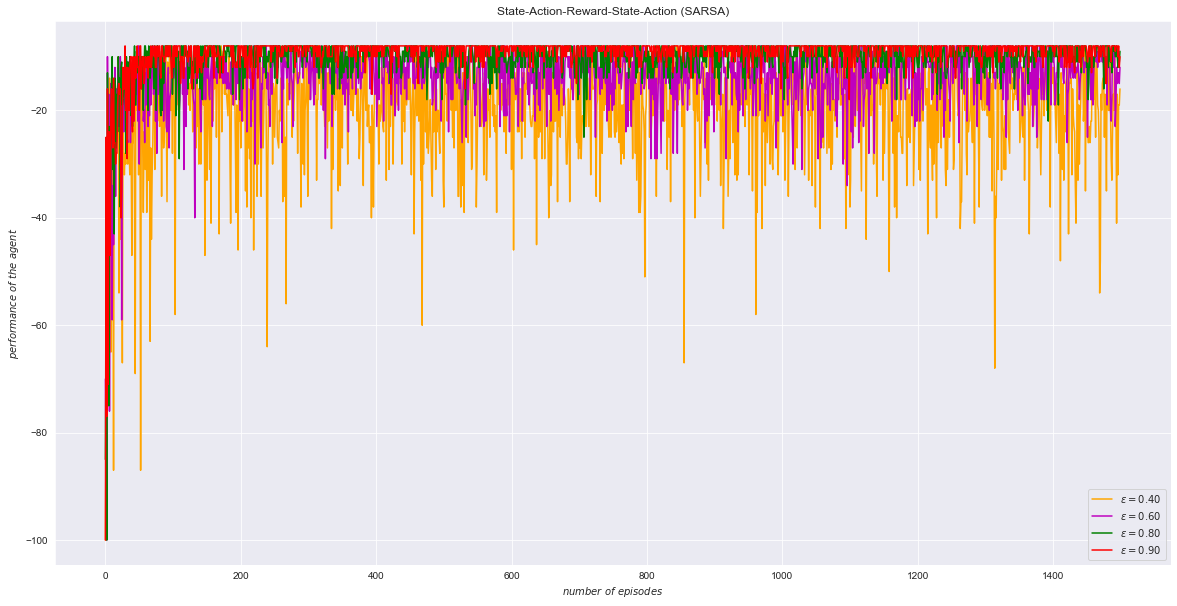

In [7]:
# Run SARSA 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilons = [0.4,0.6,0.8,0.9]
colours = ['orange','m','g','r']
x = range(episodes)

timestep_reward_SARSA,_= sarsa(alpha, world, epsilons[0], episodes, max_steps)
y = timestep_reward_SARSA
plt.figure(figsize=(20, 10))
plt.plot(x,y,colours[0],label = r'$\varepsilon = %.2f$ '%(epsilons[0]))


timestep_reward_SARSA,_= sarsa(alpha, world, epsilons[1], episodes, max_steps)
y = timestep_reward_SARSA
plt.plot(x,y,colours[1],label = r'$\varepsilon = %.2f$ '%(epsilons[1]))


timestep_reward_SARSA,_= sarsa(alpha, world, epsilons[2], episodes, max_steps)
y = timestep_reward_SARSA
plt.plot(x,y,colours[2],label = r'$\varepsilon = %.2f$ '%(epsilons[2]))



timestep_reward_SARSA,_= sarsa(alpha, world, epsilons[3], episodes, max_steps)
y = timestep_reward_SARSA
plt.plot(x,y,colours[3],label = r'$\varepsilon = %.2f$ '%(epsilons[3]))


plt.legend(loc='lower right')
plt.title('State-Action-Reward-State-Action (SARSA)')    
plt.xlabel(r'$number~of~episodes$')
plt.ylabel(r'$performance~of~the~agent$')
plt.show()

# **2c**

* Finally, show the solution your algorithm has reached for different values of $\epsilon$. <b>[10 marks]</b>

In [8]:
# Run SARSA 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilons = [0.4,0.6,0.8,0.9]

for epsilon in epsilons:
    _,SARSA_path = sarsa(alpha, world, epsilon, episodes, max_steps)
    print('\n')
    print('Path when 𝜖 = %.2f:' %(epsilon),SARSA_path )
    print()
    print(world.print_solution(SARSA_path)) 

100%|██████████| 1500/1500 [00:01<00:00, 848.40it/s]




Path when 𝜖 = 0.40: [0, 1, 6, 7, 8, 13, 18, 23, 24]

Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*|*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*|*|*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



100%|██████████| 1500/1500 [00:01<00:00, 1283.10it/s]




Path when 𝜖 = 0.60: [0, 5, 10, 15, 20, 21, 22, 23, 24]

Solution:
+-+-+-+-+-+
|S|*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



100%|██████████| 1500/1500 [00:00<00:00, 1637.56it/s]




Path when 𝜖 = 0.80: [0, 5, 6, 7, 8, 9, 14, 19, 24]

Solution:
+-+-+-+-+-+
|S|*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*|*|*|G|
+-+-+-+-+-+



100%|██████████| 1500/1500 [00:00<00:00, 1764.78it/s]




Path when 𝜖 = 0.90: [0, 5, 6, 7, 8, 13, 14, 19, 24]

Solution:
+-+-+-+-+-+
|S|*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*|*| | |
+-+-+-+-+-+
| | |*|*|G|
+-+-+-+-+-+



## 3. Q-learning 
SARSA is called an "on-policy" algorithm, because it makes assumptions on what the action that the policy will make at the next step to estimate $Q$. Therefore, the value function is dependent on the policy! 
$Q$-learning takes an alternative view, so-called "off-policy", where the value of a state-action pair is independent on the policy's actions, and is instead dependent on <i>the best possible course of action thereafter</i>. This is achieved by amending the update function: 
    $$
	Q^{(t+1)}(S_t,A_t)\leftarrow Q^{(t)}(S_t,A_t)+\alpha\left[
	R_{t+1} + \gamma \max_a Q^{(t)}(S_{t+1},a)-Q(S_t,A_t)
	\right]
	$$
    
In this part, you will:

## **3a.**
* implement the off-policy Q-learning algorithm and use it to solve the problem. <b>[10 marks]</b>

In [9]:
def qlearning(alpha, world, epsilon, episodes, max_steps):
    """
    @param alpha learning rate
    @param world the environment for the agent
    @param epsilon for exploration
    @param episodes 
    @param max_steps for max step in each episode
    """
    n_actions = len(world.actions)
    timestep_reward = []
    Q = np.zeros((len(world.states),len(world.actions)))
    final_path =[]

    for episode in tqdm(range(episodes)):
        path = []
        total_reward = 0
        current_state = world.start
        current_action = epsilon_greedy(Q, epsilon, n_actions, current_state)
        time_step = 0
        
        path.append(current_state)

        while time_step < max_steps:
            time_step += 1
            sv,rv = world.state_transition(current_state)

            reward = rv[current_action]
            new_state = sv[current_action]

            total_reward += reward
            new_action = np.argmax(Q[new_state, :]) # Chooses the best possible course of action.

            if current_state == world.goal:
                Q[current_state, current_action] += alpha * ( reward  - Q[current_state, current_action] )              
                break
            else:
                Q[current_state, current_action] += alpha * ( reward + (world.gamma * Q[new_state, new_action] ) - Q[current_state, current_action] )
                

            current_state, current_action = new_state, new_action
            path.append(current_state)


        final_path = path
        path = []
        timestep_reward.append(total_reward)      

    return (timestep_reward,final_path)




# **3b.**

* Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. <b>[10 marks]</b>

100%|██████████| 1500/1500 [00:00<00:00, 2068.97it/s]


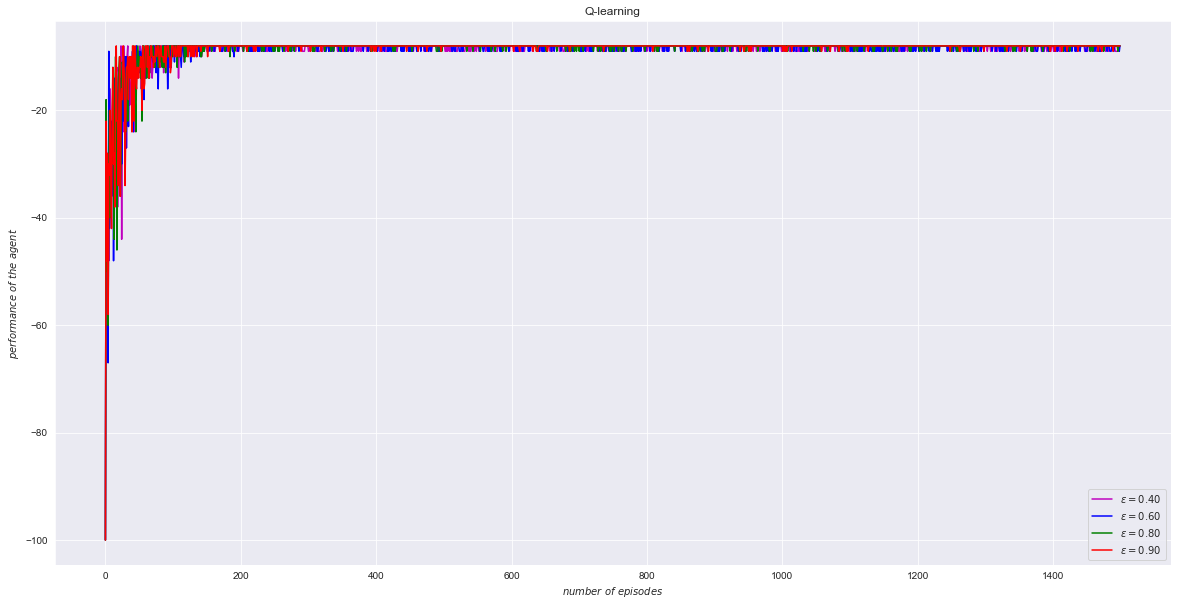

In [10]:
# Run Qlearning 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilons = [0.4,0.6,0.8,0.9]
colours = ['m','b','g','r']
x = range(episodes)

timestep_reward_Qlearning,_ = qlearning(alpha, world, epsilons[0], episodes, max_steps) 
y = timestep_reward_Qlearning
plt.figure(figsize=(20, 10))
plt.plot(x,y,colours[0],label = r'$\varepsilon = %.2f$ '%(epsilons[0]))


timestep_reward_Qlearning,_ = qlearning(alpha, world, epsilons[1], episodes, max_steps) 
y = timestep_reward_Qlearning
plt.plot(x,y,colours[1],label = r'$\varepsilon = %.2f$ '%(epsilons[1]))


timestep_reward_Qlearning,_ = qlearning(alpha, world, epsilons[2], episodes, max_steps) 
y = timestep_reward_Qlearning
plt.plot(x,y,colours[2],label = r'$\varepsilon = %.2f$ '%(epsilons[2]))


timestep_reward_Qlearning,_ = qlearning(alpha, world, epsilons[3], episodes, max_steps) 
y = timestep_reward_Qlearning
plt.plot(x,y,colours[3],label = r'$\varepsilon = %.2f$ '%(epsilons[3]))


plt.legend(loc='lower right')
plt.title('Q-learning')    
plt.xlabel(r'$number~of~episodes$')
plt.ylabel(r'$performance~of~the~agent$')
plt.show()

Clearly, by the plots above,the pattern shows that the Q-learning graphs stays roughly the same (converges quickly) even when $\epsilon$ change from 0.4 to 0.9.

# **3c.**
* Finally, show the solution your algorithm has reached for different values of $\epsilon$. <b>[10 marks]</b>

In [11]:
episodes = 1500
max_steps = 100
alpha = 0.4

for epsilon in epsilons:
    _,Qlearning_path = qlearning(alpha, world, epsilon, episodes, max_steps)
    print('\n')
    print('Path when 𝜖 = %.2f:' %(epsilon),Qlearning_path )
    print()
    print(world.print_solution(Qlearning_path)) 


100%|██████████| 1500/1500 [00:00<00:00, 1976.20it/s]




Path when 𝜖 = 0.40: [0, 5, 10, 15, 20, 21, 22, 23, 24]

Solution:
+-+-+-+-+-+
|S|*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



100%|██████████| 1500/1500 [00:00<00:00, 2007.94it/s]




Path when 𝜖 = 0.60: [0, 5, 10, 15, 20, 21, 22, 23, 24]

Solution:
+-+-+-+-+-+
|S|*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



100%|██████████| 1500/1500 [00:00<00:00, 1940.51it/s]




Path when 𝜖 = 0.80: [0, 5, 10, 15, 20, 21, 22, 23, 24]

Solution:
+-+-+-+-+-+
|S|*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



100%|██████████| 1500/1500 [00:00<00:00, 2029.78it/s]




Path when 𝜖 = 0.90: [0, 5, 10, 15, 20, 21, 22, 23, 24]

Solution:
+-+-+-+-+-+
|S|*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



Even if the value of epsilon changes the path found will be the samer because QLearning always finds the best action for each state, hence always finds the optimal solution.

Finally, compare the two algorithms on a number of gridworld configurations (see examples below, but generate a few of your own) and discuss the results. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [12]:
# Here is a function you can use for timing the training time for each algorithm. 
# This used for timing functions.
from time import time

# functions for timing execution 
# eg
tics = []
def tic(): 
    tics.append(time())
def toc(): 
    if tics: 
        return time() - tics.pop()
    else: 
        return None
    


# WORLD 1

In [13]:
world1 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], 
                                                                     [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]])
print(world1.tostring())


Grid world:
+-+-+-+-+-+-+-+-+-+-+
|S| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | |X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+



100%|██████████| 1500/1500 [00:05<00:00, 296.14it/s]




Time elapsed for SARSA ids: 5.1s


Path:  [0, 70, 71, 40, 10, 80, 50, 20, 90, 91, 60, 30]

Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|@|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |*| |*|
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | |X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+



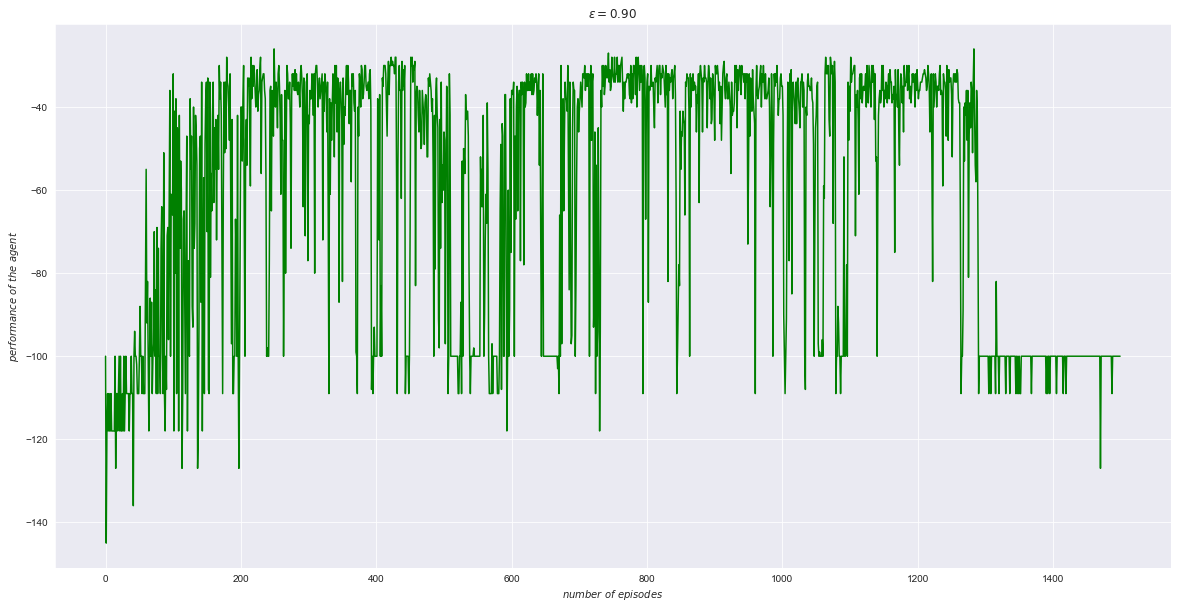

In [14]:
# Run SARSA 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilon = 0.9

# Estimate Processing time
y = 10
tic() 
timestep_reward_SARSA,SARSA_path = sarsa(alpha, world1, epsilon, episodes, max_steps) 
time_elapsed_1 = toc()
print('\n')
print('Time elapsed for SARSA ids: {:.2}s'.format(time_elapsed_1))
   

x = range(episodes)
y = timestep_reward_SARSA
plt.figure(figsize=(20, 10))
plt.plot(x,y,'g')
plt.xlabel(r'$number~of~episodes$')
plt.ylabel(r'$performance~of~the~agent$')
plt.title(r'$\varepsilon = %.2f$ '%(epsilon))
print('\n')
print('Path: ',SARSA_path)
print()
print(world1.print_solution(SARSA_path))

100%|██████████| 1500/1500 [00:02<00:00, 591.01it/s]




Time elapsed for Q-learning ids: 2.5s


Path:  [0, 10, 20, 30, 40, 50, 60, 61, 62, 63, 64, 65, 55, 45, 35, 36, 37, 47, 57, 67, 77, 87, 97, 98, 99]

Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+



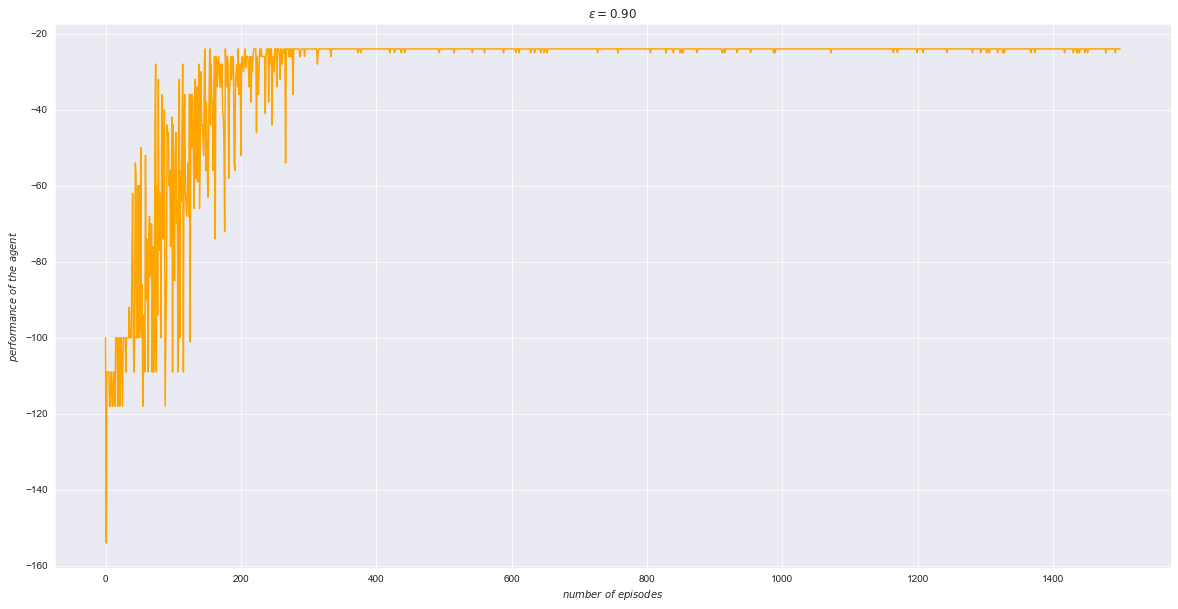

In [15]:
# Run Qlearning 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilon = 0.9


# Estimate Processing time
y = 10
tic() 
timestep_reward_Qlearning,Qlearning_path = qlearning(alpha, world1, epsilon, episodes, max_steps)
time_elapsed_2 = toc()
print('\n')
print('Time elapsed for Q-learning ids: {:.2}s'.format(time_elapsed_2))


x = range(episodes)
y = timestep_reward_Qlearning
plt.figure(figsize=(20, 10))
plt.plot(x,y,'orange')

plt.xlabel(r'$number~of~episodes$')
plt.ylabel(r'$performance~of~the~agent$')
plt.title(r'$\varepsilon = %.2f$ '%(epsilon))

print('\n')
print('Path: ',Qlearning_path)
print()
print(world1.print_solution(Qlearning_path))

In this world the performance of SARSA fluctuates as the episodes go on and some times it does not find a path from the start to the goal. This is because SARSA explores the environment more compared to Q-Learning - finds the optimal path with little exploration.

# WORLD 2

In [16]:
cliff = [ [i,j] for i in range(3,7) for j in range(3,7) ]
       
world2 = GridWorld(10,10, gamma=0.9, start=[9,0], goal=[0,9], cliff=cliff)
print(world2.tostring())

Grid world:
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |S|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|G| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+



100%|██████████| 1500/1500 [00:02<00:00, 646.27it/s]




Time elapsed for SARSA ids: 2.3s


Path:  [9, 19, 29, 39, 49, 59, 69, 79, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Solution:
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |S|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
|G|*|*|*|*|*|*|*|*|@|
+-+-+-+-+-+-+-+-+-+-+



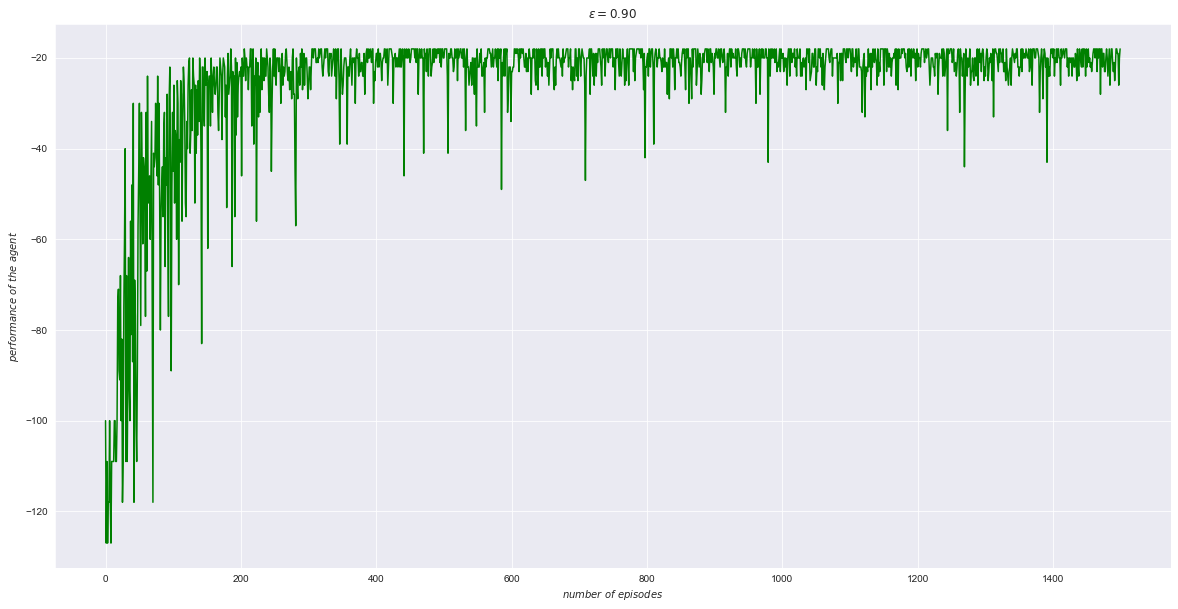

In [17]:
# Run SARSA 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilon = 0.9


# Estimate Processing time
y = 10
tic() 
timestep_reward_SARSA,SARSA_path = sarsa(alpha, world2, epsilon, episodes, max_steps) 
time_elapsed_3 = toc()
print('\n')
print('Time elapsed for SARSA ids: {:.2}s'.format(time_elapsed_3))
   

x = range(episodes)
y = timestep_reward_SARSA
plt.figure(figsize=(20, 10))
plt.plot(x,y,'g')
plt.xlabel(r'$number~of~episodes$')
plt.ylabel(r'$performance~of~the~agent$')
plt.title(r'$\varepsilon = %.2f$ '%(epsilon))
print('\n')
print('Path: ',SARSA_path)
print()
print(world2.print_solution(SARSA_path))

100%|██████████| 1500/1500 [00:02<00:00, 746.63it/s]




Time elapsed for Q-learning ids: 2.0s


Path:  [90, 80, 81, 82, 83, 73, 74, 75, 76, 77, 78, 79, 69, 59, 49, 39, 29, 19, 9]

Solution:
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*|S|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*| |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*|*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |*| | |
+-+-+-+-+-+-+-+-+-+-+
|G|*|*|*|*|*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+



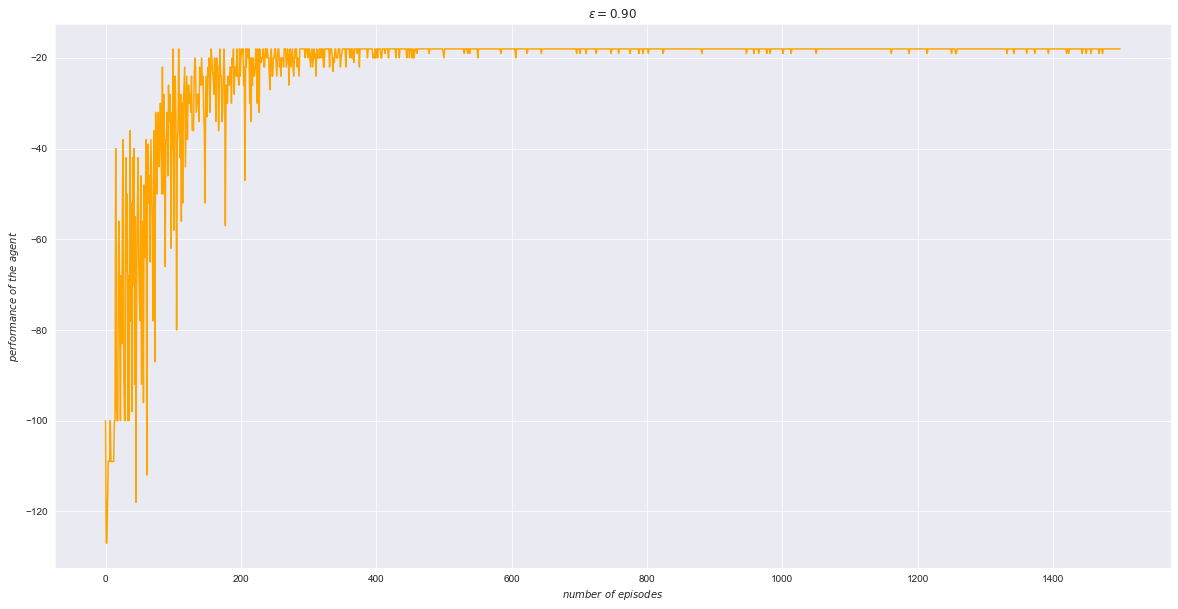

In [18]:
# Run Qlearning 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilon = 0.9

# Estimate Processing time
y = 10
tic() 
timestep_reward_Qlearning,Qlearning_path = qlearning(alpha, world2, epsilon, episodes, max_steps)
time_elapsed_4 = toc()
print('\n')
print('Time elapsed for Q-learning ids: {:.2}s'.format(time_elapsed_4))


x = range(episodes)
y = timestep_reward_Qlearning
plt.figure(figsize=(20, 10))
plt.plot(x,y,'orange')

plt.xlabel(r'$number~of~episodes$')
plt.ylabel(r'$performance~of~the~agent$')
plt.title(r'$\varepsilon = %.2f$ '%(epsilon))

print('\n')
print('Path: ',Qlearning_path)
print()
print(world2.print_solution(Qlearning_path))

# WORLD 3

In [19]:
cliff = [ [i,j] for i in range(4,8) for j in range(4,8) ]
       
world3 = GridWorld(9,11, gamma=0.9, start=[8,0], goal=[0,8], cliff=cliff)
print(world2.tostring())

Grid world:
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |S|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|G| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+



100%|██████████| 1500/1500 [00:01<00:00, 809.48it/s]




Time elapsed for SARSA ids: 1.9s


Path:  [34, 67, 5, 6, 7, 8, 45, 78, 13, 14, 15, 16, 23, 88, 89, 56, 24]

Solution:
+-+-+-+-+-+-+-+-+-+
| | | | | | | | |S|
+-+-+-+-+-+-+-+-+-+
| | |*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+
| |*|@| | | | | | |
+-+-+-+-+-+-+-+-+-+
| |*| | | | | | | |
+-+-+-+-+-+-+-+-+-+
| |*| | |X|X|X|X| |
+-+-+-+-+-+-+-+-+-+
|*|*| | |X|X|X|X| |
+-+-+-+-+-+-+-+-+-+
|*| | | |X|X|X|X| |
+-+-+-+-+-+-+-+-+-+
|*| | | |X|X|X|X| |
+-+-+-+-+-+-+-+-+-+
|G| | | | | | | | |
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+



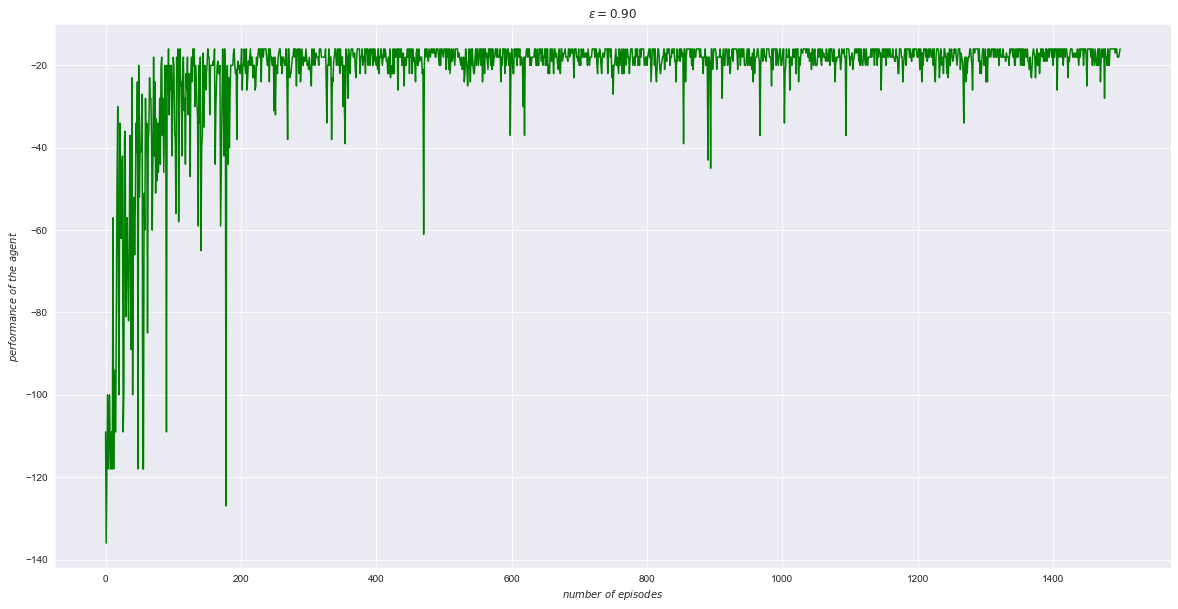

In [20]:
# Run SARSA 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilon = 0.9

# Estimate Processing time
y = 10
tic() 
timestep_reward_SARSA,SARSA_path = sarsa(alpha, world3, epsilon, episodes, max_steps) 
time_elapsed_5 = toc()
print('\n')
print('Time elapsed for SARSA ids: {:.2}s'.format(time_elapsed_5))
   

x = range(episodes)
y = timestep_reward_SARSA
plt.figure(figsize=(20, 10))
plt.plot(x,y,'g')
plt.xlabel(r'$number~of~episodes$')
plt.ylabel(r'$performance~of~the~agent$')
plt.title(r'$\varepsilon = %.2f$ '%(epsilon))
print('\n')
print('Path: ',SARSA_path)
print()
print(world3.print_solution(SARSA_path))

100%|██████████| 1500/1500 [00:01<00:00, 904.14it/s] 




Time elapsed for Q-learning ids: 1.7s


Path:  [88, 89, 90, 91, 92, 93, 94, 95, 96, 85, 74, 63, 52, 41, 30, 19, 8]

Solution:
+-+-+-+-+-+-+-+-+-+
| | | | | | | | |S|
+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+
| | | | |X|X|X|X|*|
+-+-+-+-+-+-+-+-+-+
| | | | |X|X|X|X|*|
+-+-+-+-+-+-+-+-+-+
| | | | |X|X|X|X|*|
+-+-+-+-+-+-+-+-+-+
| | | | |X|X|X|X|*|
+-+-+-+-+-+-+-+-+-+
|G|*|*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+



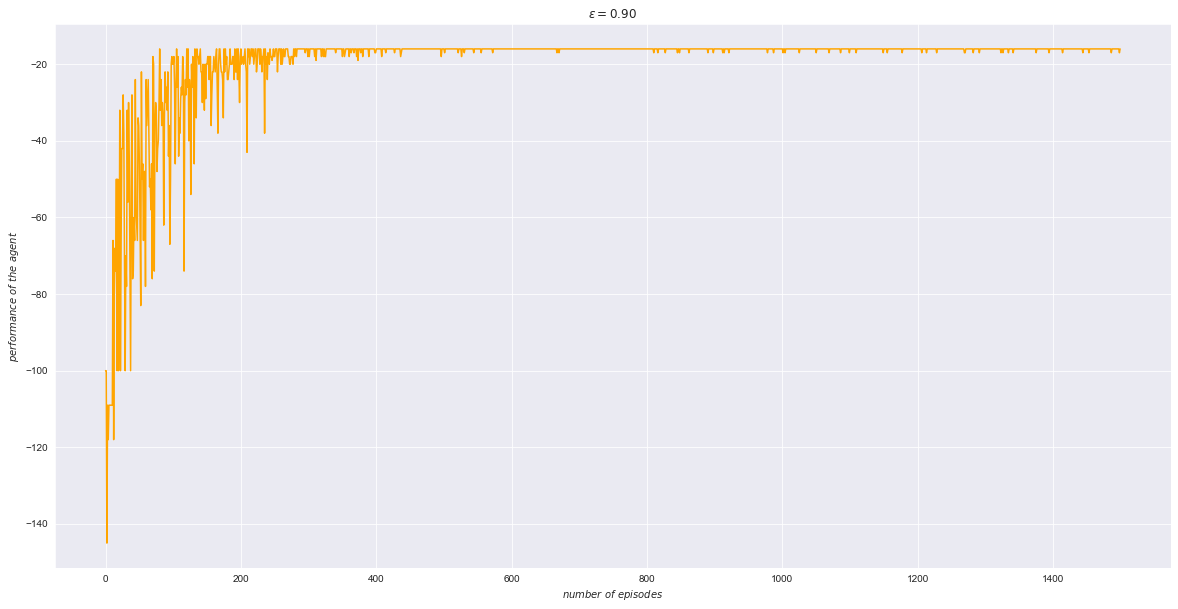

In [21]:
# Run Qlearning 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilon = 0.9

# Estimate Processing time
y = 10
tic() 
timestep_reward_Qlearning,Qlearning_path = qlearning(alpha, world3, epsilon, episodes, max_steps)
time_elapsed_6 = toc()
print('\n')
print('Time elapsed for Q-learning ids: {:.2}s'.format(time_elapsed_6))


x = range(episodes)
y = timestep_reward_Qlearning
plt.figure(figsize=(20, 10))
plt.plot(x,y,'orange')

plt.xlabel(r'$number~of~episodes$')
plt.ylabel(r'$performance~of~the~agent$')
plt.title(r'$\varepsilon = %.2f$ '%(epsilon))

print('\n')
print('Path: ',Qlearning_path)
print()
print(world3.print_solution(Qlearning_path))

# WORLD 4

In [22]:
world4 = GridWorld(6,4, gamma=0.9, goal=[5,3], start=[0,3], cliff=[[1,3],[2,3],[3,3],[4,3]])
print(world4.tostring())

Grid world:
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+



100%|██████████| 1500/1500 [00:01<00:00, 1359.93it/s]




Time elapsed for SARSA ids: 1.1s


Path:  [1, 2, 3, 5, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23]

Solution:
+-+-+-+-+-+-+
| | | |*|*|*|
+-+-+-+-+-+-+
|*|*|*|*|*|*|
+-+-+-+-+-+-+
|*| | | |*|*|
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+



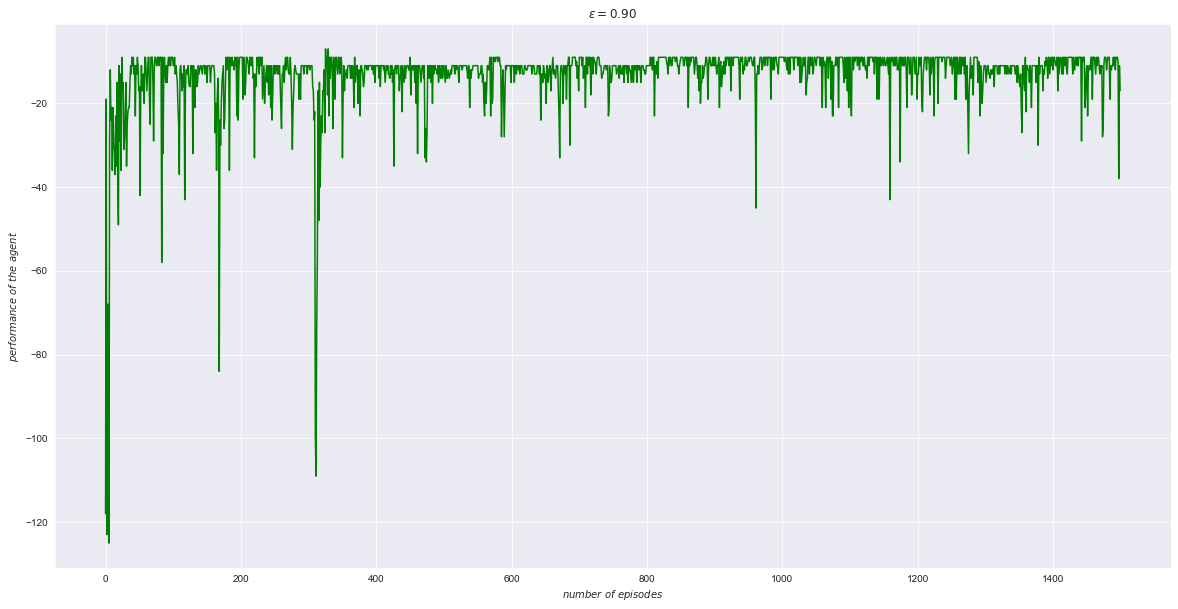

In [23]:
# Run SARSA 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilon = 0.9

# Estimate Processing time
y = 10
tic() 
timestep_reward_SARSA,SARSA_path = sarsa(alpha, world4, epsilon, episodes, max_steps) 
time_elapsed_7 = toc()
print('\n')
print('Time elapsed for SARSA ids: {:.2}s'.format(time_elapsed_7))
   

x = range(episodes)
y = timestep_reward_SARSA
plt.figure(figsize=(20, 10))
plt.plot(x,y,'g')
plt.xlabel(r'$number~of~episodes$')
plt.ylabel(r'$performance~of~the~agent$')
plt.title(r'$\varepsilon = %.2f$ '%(epsilon))
print('\n')
print('Path: ',SARSA_path)
print()
print(world4.print_solution(SARSA_path))

100%|██████████| 1500/1500 [00:00<00:00, 2255.54it/s]




Time elapsed for Q-learning ids: 0.67s


Path:  [3, 2, 6, 10, 14, 18, 22, 23]

Solution:
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|*|*|*|*|*|*|
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+



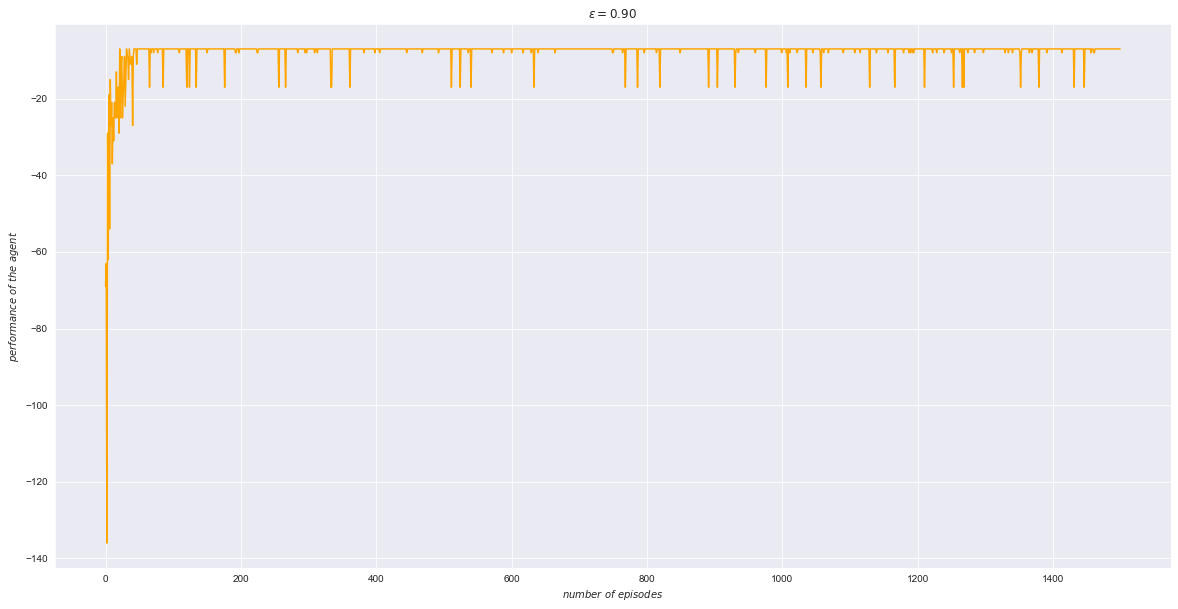

In [24]:
# Run Qlearning 
episodes = 1500
max_steps = 100
alpha = 0.4
epsilon = 0.9

# Estimate Processing time
y = 10
tic() 
timestep_reward_Qlearning,Qlearning_path = qlearning(alpha, world4, epsilon, episodes, max_steps)
time_elapsed_8 = toc()
print('\n')
print('Time elapsed for Q-learning ids: {:.2}s'.format(time_elapsed_8))


x = range(episodes)
y = timestep_reward_Qlearning
plt.figure(figsize=(20, 10))
plt.plot(x,y,'orange')

plt.xlabel(r'$number~of~episodes$')
plt.ylabel(r'$performance~of~the~agent$')
plt.title(r'$\varepsilon = %.2f$ '%(epsilon))

print('\n')
print('Path: ',Qlearning_path)
print()
print(world4.print_solution(Qlearning_path))

# **Summary**

Using four environments with different starting, ending and cliff positions (world 1,2,3 and 4) I applied the SARSA and Q-Learning. Q-Learning has the overall best performance per episode as the graphs (independent of epsilon - exploration rate)  converges quicker than SARSA.
 
### Parameters:
*  $\epsilon$ - 0.9 or 1.0 gave the quickest convergence.
*  $\alpha$ - 0.4
*  $\gamma$ - 1.0
*  episodes - 1500
*  max_steps - 100 (max number of time steps possible in a single episode)
 



The $\epsilon$ value specifies the agent's exploitation.
If $\epsilon$ is high, the random number $r$ will hardly ever be greater than $\epsilon$, and a random action will hardly be taken (less discovery, more exploitation). If $\epsilon$ is small, the random number $r$ will almost always be greater than $\epsilon$, which will cause the agent to choose more random actions. This random trait will allow the agent to further explore the environment.
In general, $\epsilon$ is chosen as 0.9 but it can vary based on the type of environment. In certain instances, $\epsilon$ is rinsed for further discovery and more activities over time.

$\alpha$ is commonly called a learning rate. I chose 0.4 because it offered the best result between 0 and 1.

###### A summary table of the best performance along with the estimated processing time obtained by each algorithm in my experiments.

|  | SARSA | QLearning |
| --- | --- | --- |
| World 1- Estimated Processing Time (s)| 8.6| 3.1 |
| World 2- Estimated Processing Time (s)| 3.0 | 2.4 |
| World 3- Estimated Processing Time (s)| 3.7 | 2.9 |
| World 4- Estimated Processing Time (s)| 1.6 | 0.97 |

Note: The exact values might change if the kernel restarts and runs again, however the diffrence in processing time between the two algorithm for each world remains the same.


The table above highlights the estimated performance of Q-Learning compared to SARSA. Q-Learning takes less estimated processing time than SARSA in all environments (world 1 to 4). This shows that QLearning performs better and takes less time to run compared to SARSA. The reason is because Q-learning finds the optimal strategy, but achieves lower reward due to $\epsilon$-greedy policy and SARSA learns safer, but longer path.